# Visualization using Makie
This notebook shows how to do mesh and data visualization using the ``Makie.jl`` package.

The presented code is based on the ``GridapMakie.jl`` package, and adapted for the home-brew FEM implementation used in the course.

In [2]:
using Gmsh

using CairoMakie
using GeometryBasics

CairoMakie.activate!(type = "svg")

## Obtain Mesh Data
We will encounter two types of data which we want to plot:
1. Data defined on the nodes. For example, the unknown $u(x,y)$
2. Data defined on the elements. For example, the derivatives, gradients, etc. of $u(x,y)$

These two variants will be handled separately.

In [3]:
# Obtain a GeometryBasics.Mesh object suitable for plotting with Makie
function get_node_mesh()
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nNode = length(node_ids)

    eType, eTag, eConn = gmsh.model.mesh.getElements(2);
    nEl = length(eTag[1])

    points   = zeros(Point2f, nNode);          # Array of vertex coordinates (x,y)
    trif     = zeros(TriangleFace{Int}, nEl);  # Array of triangular faces (n1, n2, n3)
    
    for n in 1:nNode
        points[node_ids[n]] = Point2f(node_coord[3*(n-1) + 1], node_coord[3*(n-1) + 2])
    end
    for e in 1:nEl
        trif[e] = (eConn[1][3*(e-1)+1], eConn[1][3*(e-1)+2], eConn[1][3*(e-1)+3])
    end
    
    msh = GeometryBasics.Mesh(points, trif);
    return msh;
end

get_node_mesh (generic function with 1 method)

In [4]:
function get_cell_mesh(cell_val)
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nNode = length(node_ids)

    eType, eTag, eConn = gmsh.model.mesh.getElements(2);
    nEl = length(eTag[1])
    
    points   = zeros(Point2f, nEl * 3);        # Array of vertex coordinates (x,y)
    trif     = zeros(TriangleFace{Int}, nEl);  # Array of triangular faces (n1, n2, n3)
    node_val = zeros(Float64, nEl * 3);

    for e = 1:nEl
        n1idx = 3 * (e - 1) + 1; n1 = eConn[1][n1idx];
        n2idx = 3 * (e - 1) + 2; n2 = eConn[1][n2idx];
        n3idx = 3 * (e - 1) + 3; n3 = eConn[1][n3idx];

        points[n1idx] = Point2f(node_coord[3*(n1-1) + 1], node_coord[3*(n1-1) + 2])
        points[n2idx] = Point2f(node_coord[3*(n2-1) + 1], node_coord[3*(n2-1) + 2])
        points[n3idx] = Point2f(node_coord[3*(n3-1) + 1], node_coord[3*(n3-1) + 2])
        
        node_val[n1idx] = cell_val[e];
        node_val[n2idx] = cell_val[e];
        node_val[n3idx] = cell_val[e];

        trif[e] = (3 * (e - 1) + 1, 3 * (e - 1) + 2, 3 * (e - 1) + 3);
    end

    msh = GeometryBasics.Mesh(points, trif);
    
    return msh, node_val
end

get_cell_mesh (generic function with 1 method)

## Example: Square with Hole

Info    : Reading 'geo_files/square_hole.msh'...
Info    : 17 entities
Info    : 116 nodes
Info    : 240 elements
Info    : Done reading 'geo_files/square_hole.msh'


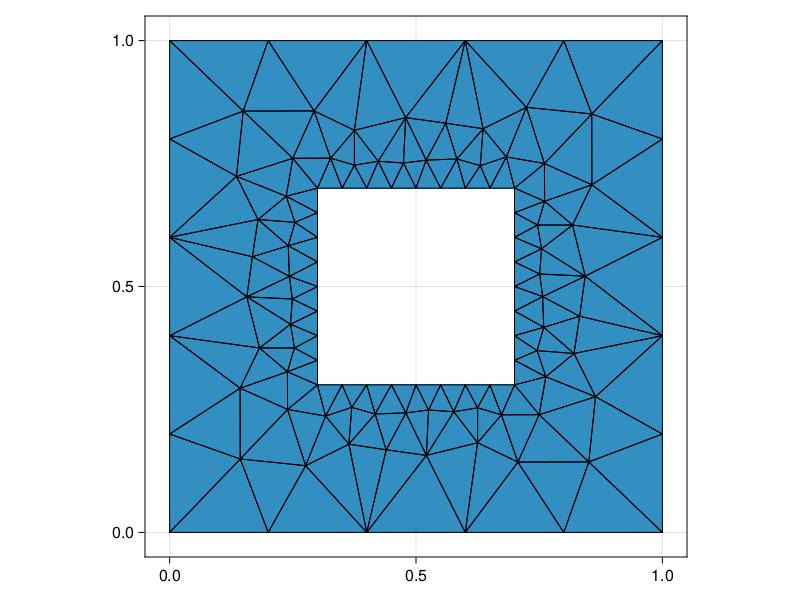

In [5]:
gmsh.initialize()
gmsh.open("geo_files/square_hole.msh")

msh = get_node_mesh()

f, ax, pl = mesh(msh, shading = false)
wireframe!(ax, msh, color=(:black), linewidth=1, transparency=false)
ax.aspect = AxisAspect(1)
current_figure()

In [ ]:
save("figures/unit_square_hole.svg", f)

![Mesh: Unit Square with a Hole](figures/unit_square_hole.svg)

## Example: Coaxial Cable

In [ ]:
gmsh.initialize()
gmsh.open("geo_files/coaxial_cable.msh")

In [ ]:
#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Create groups of elements for the subdomains
#..for loop that creates a vector describing which physical group an element belongs to
ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 2)
e_group = zeros(1,nelements)
for element_id in 1:nelements
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]
    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) # Conductor
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) # Insulator
    if G1 == 3
        e_group[element_id] = 1;
    elseif G2 == 3
        e_group[element_id] = 2;
    end
end

In [ ]:
cell_val = e_group;
msh, colors = get_cell_mesh(cell_val);

f, ax, pl = mesh(msh, color = colors, colormap = :lighttest, shading = false)
wireframe!(ax, msh, color=(:black), linewidth=1, transparency=false)
ax.aspect = AxisAspect(1)
current_figure()

In [ ]:
save("figures/coaxial_cable.svg", f)

![Mesh: Coaxial Cable](figures/coaxial_cable.svg)